In [1]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
import data_analysis_codes.tools.GetVars_Plot2d as gvar
import data_analysis_codes.tools.ReadingTools as RRead
import data_analysis_codes.tools.LinData as LinData
from data_analysis_codes.tools import TAradius

In [2]:
param = RRead.read_parameters('pflrw_d3e2_L1821_t1_N128_LCDM')
Lin = LinData.LinData_Class(param)
ODid = int(param['Nx']/4)
TAr = TAradius.TA_Class(param, Lin, ([ODid], [ODid], [ODid]))
gv = gvar.Get_var(param, Lin)
path = (param['HorSpath'] + param['simname']
        + '/output-0000/' + param['simname'] 
        + '/all_iterations/' + param['simname'])

 read time file


In [3]:
def get_r_var(it):
    
    filename = '{}_it_{:06d}.hdf5'.format(path, it)
    f = h5py.File(filename, 'r')
    Kdict = gv.get_the_curv(f, it)
    gdet = Kdict['metric_dic']['gdet']
    A2 = Kdict['A2']
    r = []
    var = []
    for theta, phi, dxfac in zip([0, np.pi/4, np.pi/4], 
                                 [0, 0, np.pi/4], 
                                 [1.0, np.sqrt(2), np.sqrt(3)]):
        right_values = TAr.idx_along_r(theta, phi, dxfac)[1]
        coord, radius, indices, radius_from_indices, weighted_dx = right_values

        for i in range(len(radius_from_indices)): 
            #this for loop is to find the correct i
            if radius_from_indices[i]>1.05*dxfac*param['Lx']/2:
                break

        var += [np.array([A2[i] for i in indices[:i]])]

        gdet_along_radius_save = np.array([gdet[i] for i in indices[:i]])
        weighted_dx_save = weighted_dx[:i]

        proper_radius = [0]
        for j in range(1, i):
            proper_radius += [proper_radius[-1]
                              + (gdet_along_radius_save[j]**(1/6))
                              * weighted_dx_save[j]]

        com_radius = [0]
        for j in range(1, i):
            com_radius += [com_radius[-1] +  weighted_dx_save[j]]
        r += [np.array(com_radius)]
    return r, var

In [8]:
its = Lin.temporal_file['it'][0::param['IOHDF5::out_every']]

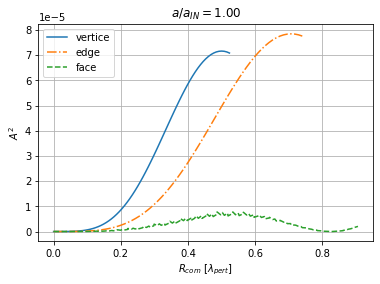

In [9]:
for it in [0]:
    r, var = get_r_var(int(it))
    plt.figure()
    plt.plot(r[0]/param['Lx'], var[0], linestyle='-', label='vertice')
    plt.plot(r[1]/param['Lx'], var[1], linestyle='-.', label='edge')
    plt.plot(r[2]/param['Lx'], var[2], linestyle='--', label='face')
    plt.grid()
    plt.legend(loc=2)
    plt.ylabel(r'$A^2$')
    plt.xlabel(r'$R_{com}$'+' ['+r'$\lambda_{pert}$'+']')
    plt.title(r'$a/a_{IN}=$'+'{:.2f}'.format(Lin.temp_from_temp('an', 'it', it)))